In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

np.random.seed(42)

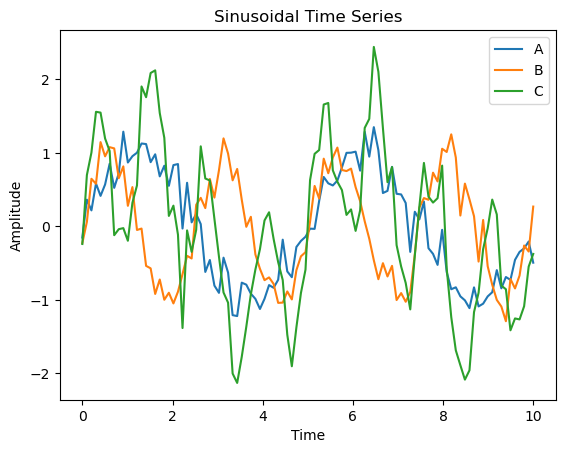

In [15]:


# Step 1: Generate Sinusoidal Time Series
t = np.linspace(0, 10, 1000)   # Time vector
A = np.sin(2 * np.pi * 0.2 * t) + np.random.randn(len(t))/5  # Time series A with noise
B = np.sin(2 * np.pi * 0.4 * t) + np.random.randn(len(t))/5# Time series B
C = np.sin(2 * np.pi * 0.8 * t) + A + np.random.randn(len(t))/5  # Time series C

#plot
plt.figure()
plt.plot(t, A, label='A')
plt.plot(t, B, label='B')
plt.plot(t, C, label='C')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sinusoidal Time Series')
plt.show()

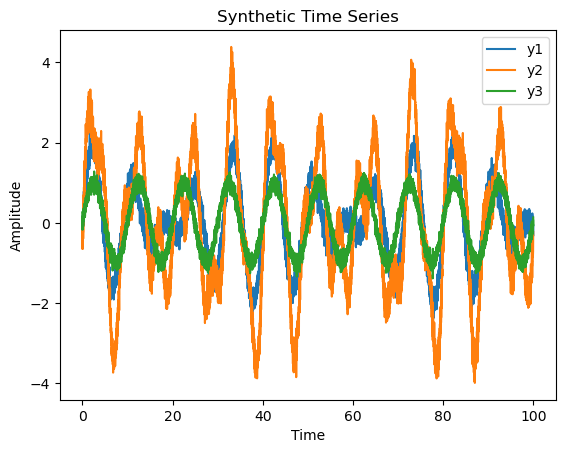

In [5]:
#v1
sfreq = 100 # Hz
tmin = 0 # s
tmax = 100 # s
time = np.arange(tmin, tmax, 1/sfreq) 

c_1_2 = 1
c_3_1 = 1
c_3_2 = 1

f1 = 0.125
f2 = 0.25
f3 = 0.10

signal1 = np.sin(2*np.pi*f1*time)
signal2 = np.sin(2*np.pi*f2*time)
signal3 = np.sin(2*np.pi*f3*time)

snr1 = 0.1
snr2 = 0.1
snr3 = 0.1

noise1 = np.random.randn(len(time))
noise2 = np.random.randn(len(time))
noise3 = np.random.randn(len(time))

phase_y1_y3 = 0.5*np.pi
phase_y2_y3 = np.pi
phase_y1_y2 = 0.25*np.pi

lag1 = np.int64((phase_y1_y3/(2*np.pi)*sfreq))
lag2 = np.int64((phase_y2_y3/(2*np.pi)*sfreq))
lag3 = np.int64((phase_y1_y2/(2*np.pi)*sfreq))

y3_a = signal3 + noise3*snr3 
y1_a = signal1 + noise1*snr1 + c_3_1*np.roll(y3_a, lag1)
y2_a = signal2 + noise2*snr2 + c_3_2*np.roll(y3_a, lag2) + c_1_2*np.roll(y1_a, lag3)

#plot
plt.figure()
plt.plot(time, y1_a, label='y1')
plt.plot(time, y2_a, label='y2')
plt.plot(time, y3_a, label='y3')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Synthetic Time Series')
plt.show()

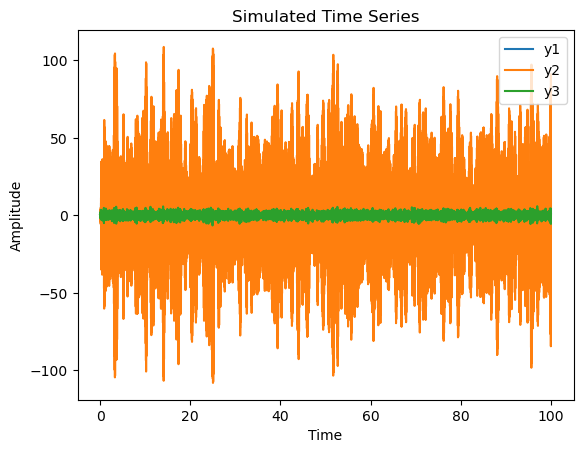

In [129]:
#v2
sfreq = 100
tmin = 0 # s
tmax = 100 # s
time = np.arange(tmin, tmax, 1/sfreq) 
rho = 0.9

np.random.seed(42)
noise1 = np.random.randn(len(time))
noise2 = np.random.randn(len(time))
noise3 = np.random.randn(len(time))

y1_a = np.zeros(len(time))
y2_a = np.zeros(len(time))
y3_a = np.zeros(len(time))

y1_a[0] = noise1[0]
y1_a[1] = noise1[1]    
y2_a[0] = noise2[0]    
y2_a[1] = noise2[1]    
y3_a[0] = noise3[0]
y3_a[1] = noise3[1]

# y1 y2 preseent
for i in np.arange(4, len(time)):
    y3_a[i] = -(rho**2)*y3_a[i-2] + noise3[i]
    y1_a[i] = y3_a[i-2]-(rho**2)*y1_a[i-2] + noise1[i]
    y2_a[i] = y3_a[i-2] + y1_a[i-4] - (rho**2)*y2_a[i-2] + noise2[i]

#y1 y2 not present
"""for i in np.arange(2, len(time)):
    y3_a2[i] = -(rho**2)*y3_a2[i-2] + noise3[i]
    y1_a2[i] = y3_a2[i-2]-(rho**2)*y1_a2[i-2] + noise1[i]
    y2_a2[i] = y3_a2[i-2] - (rho**2)*y2_a2[i-2] + noise2[i]"""

#Plot
plt.figure()
plt.plot(time, y1_a2, label='y1')
plt.plot(time, y2_a2, label='y2')
plt.plot(time, y3_a2, label='y3')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Simulated Time Series')
plt.show()

<Axes: >

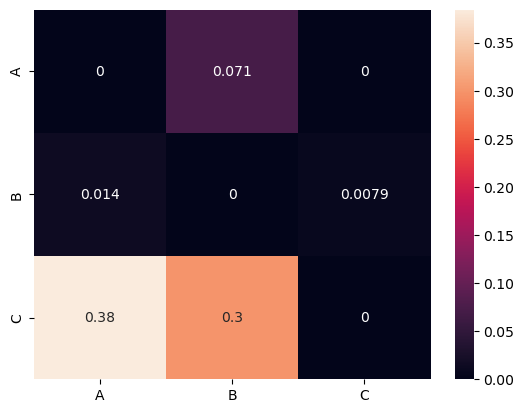

In [18]:
# Manual ESN Implementation
class SimpleESN:
    def __init__(self, n_reservoir, spectral_radius, sparsity,rho=0.9, noise=0.1,alpha=1.0,leaky_rate=0.1):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.state = np.zeros(n_reservoir)
        self.W = None
        self.W_in = None
        self.W_out = None
        self.rho = rho
        self.noise = noise
        self.alpha = alpha
        self.leaky_rate = leaky_rate


    def initialize_weights(self):
        # Internal weights
        W = np.random.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # Set sparsity
        W[np.random.rand(*W.shape) > self.sparsity] = 0
        # Scale weights to have the desired spectral radius
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
        # Input weights
        self.W_in = np.random.rand(self.n_reservoir, 1) * 2 - 1

    def update_state(self, input):
        pre_activation = np.dot(self.W, self.state) + np.dot(self.W_in, input)
        updated_state = np.tanh(pre_activation)
        self.state = self.leaky_rate * updated_state + (1 - self.leaky_rate) * self.state


    def train(self, inputs, outputs):
        # Initialize weights
        self.initialize_weights()
        
        # Collect states for training
        states = []
        for input in inputs:
            self.update_state(input)
            states.append(self.state.copy())
        
        # Train the readout layer
        reg = LinearRegression()
        reg.fit(states, outputs)
        self.W_out = reg.coef_
    
    def predict(self, inputs):
        states = []
        for input in inputs:
            self.update_state(input)
            states.append(self.state.copy())
        
        return np.dot(states, self.W_out.T)

# Function to train an ESN and calculate MSE for a given input-output pair
def train_and_evaluate(input_series, target_series):
    esn = SimpleESN(n_reservoir=15, spectral_radius=.8, sparsity=.2)
    esn.train(input_series[:-1, np.newaxis], target_series[1:])
    predictions = esn.predict(input_series[:-1, np.newaxis]).flatten()
    mse = np.mean((predictions - target_series[1:])**2)
    return mse

# Time series in a list for easier iteration
time_series = [A, B, C]
mse_results = np.zeros((3, 3))

# Step 3: Train ESNs for Each Time Series Pair and Evaluate
for i in range(3):
    for j in range(3):
        if i != j:
            mse_results[i, j] = train_and_evaluate(time_series[i], time_series[j])
        else:
            mse_results[i, j] = train_and_evaluate(time_series[i], np.roll(time_series[j],-2))

# Invert MSE for adjacency matrix (higher value means stronger predictive power)
adjacency_matrix = np.where(mse_results != 0, 1 / mse_results, 0)

#Normalize the adjacency matrix between 0 and 1
adjacency_matrix = (adjacency_matrix - np.min(adjacency_matrix)) / (np.max(adjacency_matrix) - np.min(adjacency_matrix))

#Fill diagonal with zeros
np.fill_diagonal(adjacency_matrix, 0)

sns.heatmap(adjacency_matrix, annot=True, xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'])


/Users/erikconnerty/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([999, 1, 1])) that is different to the input size (torch.Size([999, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.5215362906455994
Epoch 2, Loss: 0.5210767984390259
Epoch 3, Loss: 0.5206716060638428
Epoch 4, Loss: 0.5202030539512634
Epoch 5, Loss: 0.5204680562019348
Epoch 6, Loss: 0.5204969644546509
Epoch 7, Loss: 0.5202898383140564
Epoch 8, Loss: 0.5202035307884216
Epoch 9, Loss: 0.5202987790107727
Epoch 10, Loss: 0.5203649401664734
MSE between A and B: 0.5203010439872742
Epoch 1, Loss: 1.0570173263549805
Epoch 2, Loss: 1.0598788261413574
Epoch 3, Loss: 1.0570160150527954
Epoch 4, Loss: 1.0571215152740479
Epoch 5, Loss: 1.0576961040496826
Epoch 6, Loss: 1.0574764013290405
Epoch 7, Loss: 1.0570025444030762
Epoch 8, Loss: 1.0567903518676758
Epoch 9, Loss: 1.0569599866867065
Epoch 10, Loss: 1.0571086406707764
MSE between A and C: 1.0569946765899658
Epoch 1, Loss: 0.5237157940864563
Epoch 2, Loss: 0.5274268388748169
Epoch 3, Loss: 0.523952305316925
Epoch 4, Loss: 0.5241638422012329
Epoch 5, Loss: 0.5248293876647949
Epoch 6, Loss: 0.5244396924972534
Epoch 7, Loss: 0.5238498449325562
E

<Axes: >

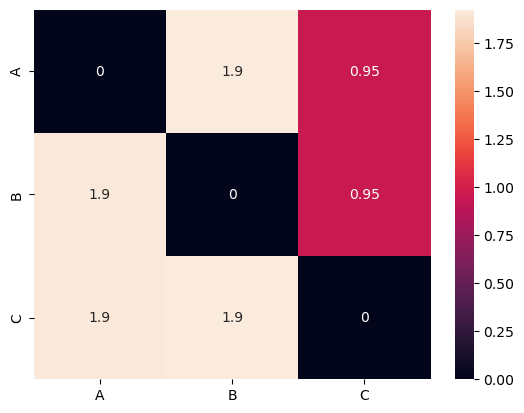

In [66]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True,num_layers=4,dropout=0.2)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        output, _ = self.gru(x)
        output = self.linear(output[:, -1, :])  # Take the output of the last time step
        return output
def train_model(model, train_x, train_y, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        loss.backward()
        optimizer.step()
    return model

# Initialize models
input_size = 1  # Assuming univariate time series
hidden_size = 500  # Can be adjusted
output_size = 1
models = {}

A_tensor = torch.from_numpy(A).float().unsqueeze(-1)  # Convert A to tensor and reshape
B_tensor = torch.from_numpy(B).float().unsqueeze(-1)  # Convert B to tensor and reshape
C_tensor = torch.from_numpy(C).float().unsqueeze(-1)  # Convert C to tensor and reshape

# Assuming A, B, C are your PyTorch Tensor datasets
time_series_data = {'A': A_tensor, 'B': B_tensor, 'C': C_tensor}
adjacency_matrix = np.zeros((3, 3))
time_series_keys = list(time_series_data.keys())

time_lag = 0  # Define the constant time lag you wish to introduce

for i, ts_i in enumerate(time_series_keys):
    for j, ts_j in enumerate(time_series_keys):
        if i != j:
            # Assuming time_series_data contains PyTorch tensors after conversion
            # Adjust the training and target series for time lag
            train_series = time_series_data[ts_i][:-time_lag-1].unsqueeze(-1)
            target_series = time_series_data[ts_j][time_lag+1:].unsqueeze(-1)  # Target is shifted by 'time_lag'

            model = GRUModel(input_size, hidden_size, output_size)
            model = train_model(model, train_series, target_series)
            predicted = model(time_series_data[ts_i][:-time_lag-1].unsqueeze(-1))
            
            # Adjust the comparison of predicted and actual values to account for the time lag
            mse = nn.MSELoss()(predicted, time_series_data[ts_j][time_lag+1:].unsqueeze(-1))
            print(f'MSE between {ts_i} and {ts_j}: {mse.item()}')
            adjacency_matrix[i, j] = 1 / mse.item()  # Inverse MSE

sns.heatmap(adjacency_matrix, annot=True, xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'])
